In [84]:
import pandas as pd
import numpy as np
import os
import keras
from keras.utils import to_categorical
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

from keras.layers import Bidirectional, LSTM

In [50]:
df = pd.read_csv("train_df_features.csv")

In [51]:
print(df.head())

              row_id sequence_type sequence_id  sequence_counter      subject  \
0  SEQ_000091_000000        Target  SEQ_000091                 0  SUBJ_032233   
1  SEQ_000091_000001        Target  SEQ_000091                 1  SUBJ_032233   
2  SEQ_000091_000002        Target  SEQ_000091                 2  SUBJ_032233   
3  SEQ_000091_000003        Target  SEQ_000091                 3  SUBJ_032233   
4  SEQ_000091_000004        Target  SEQ_000091                 4  SUBJ_032233   

       orientation                       behavior       phase  \
0  Seated Straight  Moves hand to target location  Transition   
1  Seated Straight  Moves hand to target location  Transition   
2  Seated Straight  Moves hand to target location  Transition   
3  Seated Straight  Moves hand to target location  Transition   
4  Seated Straight  Moves hand to target location  Transition   

                 gesture     acc_x  ...  tof_5_mean  tof_5_std  tof_5_min  \
0  Above ear - pull hair -4.492188  ...      

In [52]:
channels = 5
pixels_per_image = channels * 8 * 8  


usable_size = (tof_data.size // pixels_per_image) * pixels_per_image  
tof_data = tof_data.flatten()[:usable_size]  

X_images = tof_data.reshape(-1, channels, 8, 8).transpose(0, 2, 3, 1)
X_images = X_images[:len(Ytrain)]
print("X_images shape:", X_images.shape)

Ytrain = df["sequence_type"].iloc[:X_images.shape[0]].values

print("Ytrain: ", Ytrain.shape)

X_images shape: (457218, 8, 8, 5)
Ytrain:  (457218,)


In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(
    np.array(X_images), np.array(Ytrain),test_size=0.20, random_state=42)
    


print(f"X train shape: {X_train.shape}")
print(f"Y train shape: {Y_train.shape}")
print(f"X test shape: {X_test.shape}")
print(f"Y test shape: {Y_test.shape}")

Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

X_train = X_train / 255.0
X_test = X_test / 255.0

In [85]:
def tof_cnn_model(input_shape=(8,8,5), num_classes=2):
    inputs = keras.Input(shape=input_shape)

    #1st Conv Block
    x = keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2,2))(x)

    #2nd Conv Block
    x = keras.layers.Conv2D(64,(3,3), activation = "relu", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2,2))(x)

    #3th Con Block
    x = keras.layers.Conv2D(128,(3,3), activation = "relu", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.GlobalAveragePooling2D()(x)


    x = keras.layers.Dense(128, activation="relu")(x)
    x = keras.layers.Dropout(0.4)(x)
    
    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)


    model = keras.Model(inputs,outputs)
    return model
    


In [99]:
def CNN_BiLSTM_model(input_shape=(64,5), num_classes=2):
    """
    CNN + BiLSTM hybrid model for sequential sensor data"
    """
    inputs = keras.Input(shape = input_shape)

    #First block
    Z1 = keras.layers.Conv1D(64, 3, activation="relu")(inputs)
    B1 = keras.layers.BatchNormalization()(Z1)
    P1 = keras.layers.MaxPooling1D(2)(B1)
    D1 = keras.layers.Dropout(0.30)(P1)

    #Second Block
    Z2 = keras.layers.Conv1D(128, 5, activation="relu")(D1)
    B2 = keras.layers.BatchNormalization()(Z2)
    Z3 = keras.layers.Conv1D(128, 5, activation="relu")(B2)
    P2 = keras.layers.MaxPooling1D(2)(Z3)
    D2 = keras.layers.Dropout(0.40)(P2)

    BILSTM = Bidirectional(LSTM(128, return_sequences=True))(D2)
    D3 = keras.layers.Dropout(0.40)(BILSTM)

    G1 = keras.layers.GlobalAveragePooling1D()(D3)

    x = keras.layers.Dense(512, activation="relu")(G1)
    B3 = keras.layers.BatchNormalization()(x)
    D4 = keras.layers.Dropout(0.50)(B3)
    x2 = keras.layers.Dense(256, activation="relu")(D4)
    D5 = keras.layers.Dropout(0.30)(x2)

    outputs = keras.layers.Dense(num_classes, activation="softmax")(D5)
    model = keras.Model(inputs, outputs)

    return model
    

    

In [102]:
Y_train_encoded = encoder.fit_transform(Y_train)
Y_test_encoded = encoder.transform(Y_test)

unique, counts = np.unique(Y_train_encoded, return_counts=True)
print(dict(zip(unique, counts)))

class_weights = compute_class_weight('balanced', classes=np.unique(Y_train_encoded), y=Y_train_encoded)
class_weights = dict(enumerate(class_weights))
X_train_seq = X_train.reshape(-1, 64, 5)
X_test_seq = X_test.reshape(-1, 64, 5)

{0: 98332, 1: 221720}


In [105]:
ConvModel = CNN_BiLSTM_model(input_shape=(64,5),num_classes=2)
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

encoder = LabelEncoder()

Y_train_cat = to_categorical(Y_train_encoded, num_classes=2)
Y_test_cat = to_categorical(Y_test_encoded, num_classes=2)
ConvModel.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = ConvModel.fit(X_train_seq, 
                        Y_train_cat, 
                        epochs=10,
                        batch_size=32, 
                        validation_data=(X_test_seq, Y_test_cat),
                        class_weight=class_weights
                       )
ConModel.summary()


Epoch 1/10
10002/10002 ━━━━━━━━━━━━━━━━━━━━ 348s 34ms/step - accuracy: 0.5683 - loss: 0.6942 - val_accuracy: 0.6039 - val_loss: 0.6599
Epoch 2/10
10002/10002 ━━━━━━━━━━━━━━━━━━━━ 345s 34ms/step - accuracy: 0.6260 - loss: 0.6377 - val_accuracy: 0.6554 - val_loss: 0.5979
Epoch 3/10
10002/10002 ━━━━━━━━━━━━━━━━━━━━ 347s 35ms/step - accuracy: 0.6502 - loss: 0.6212 - val_accuracy: 0.6397 - val_loss: 0.6310
Epoch 4/10
10002/10002 ━━━━━━━━━━━━━━━━━━━━ 345s 35ms/step - accuracy: 0.6624 - loss: 0.6143 - val_accuracy: 0.6653 - val_loss: 0.5987
Epoch 5/10
10002/10002 ━━━━━━━━━━━━━━━━━━━━ 347s 35ms/step - accuracy: 0.6690 - loss: 0.6077 - val_accuracy: 0.6654 - val_loss: 0.6011
Epoch 6/10
10002/10002 ━━━━━━━━━━━━━━━━━━━━ 347s 35ms/step - accuracy: 0.6717 - loss: 0.6028 - val_accuracy: 0.6645 - val_loss: 0.6006
Epoch 7/10
10002/10002 ━━━━━━━━━━━━━━━━━━━━ 347s 35ms/step - accuracy: 0.6772 - loss: 0.5990 - val_accuracy: 0.6786 - val_loss: 0.5756
Epoch 8/10
10002/10002 ━━━━━━━━━━━━━━━━━━━━ 346s 35ms/s

NameError: name 'ConModel' is not defined

/tmp/ipykernel_194/974158325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/tmp/ipykernel_194/974158325.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

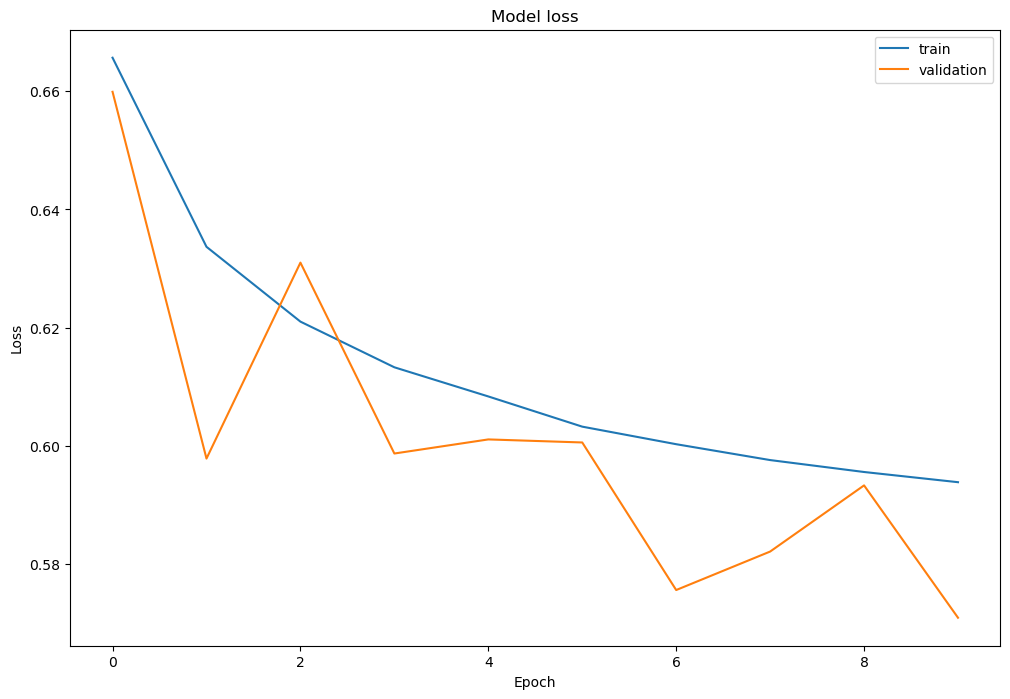

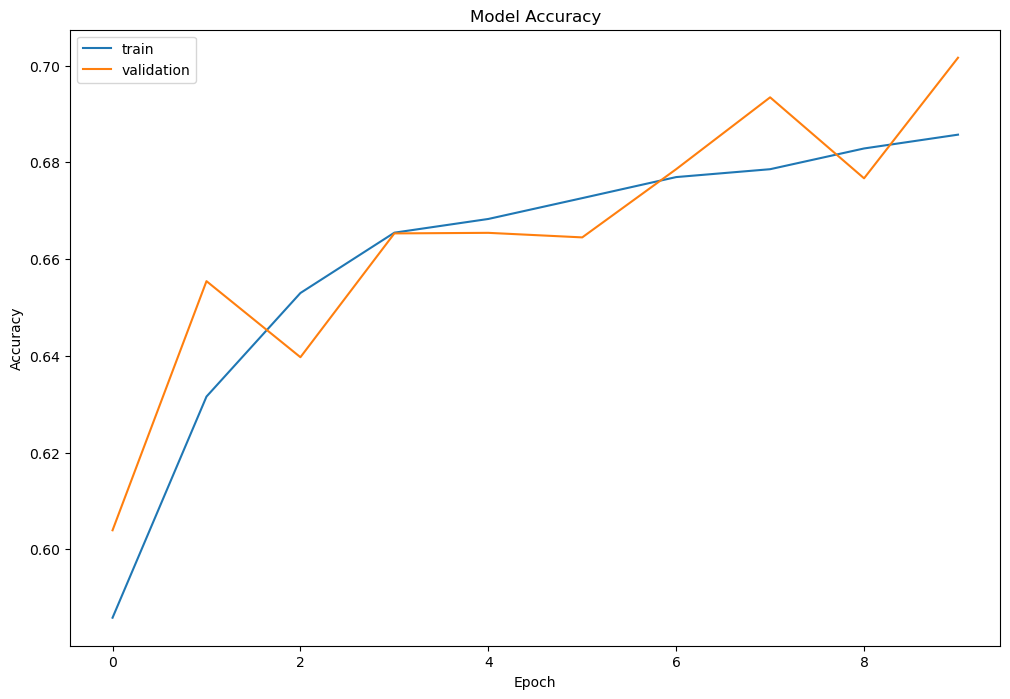

In [106]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')